In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kstest, jarque_bera, shapiro, f, binom_test, ttest_1samp
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy.stats import genextreme as gev
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = "--"
plt.rcParams['savefig.facecolor']='white'

# 1. Analiza jednowymiarowa.

## Przygotowanie danych.

In [2]:
cocoa = pd.read_csv('Cocoa.csv')
milk = pd.read_csv('Milk.csv')
sugar = pd.read_csv('Sugar.csv')

In [3]:
cocoa.head()

,Date,Close/Last,Volume,Open,High,Low
0,04/22/2022,2554,NaN,2554,2554,2554
1,04/21/2022,2592,NaN,2592,2592,2592
2,04/20/2022,2593,NaN,2593,2593,2593
3,04/19/2022,2580,NaN,2580,2580,2580
4,04/18/2022,2578,NaN,2578,2578,2578


In [4]:
milk.head()

,Date,Close/Last,Volume,Open,High,Low
0,04/22/2022,24.55,763.0,24.57,24.75,24.45
1,04/21/2022,24.57,670.0,24.09,24.64,23.88
2,04/20/2022,24.17,1117.0,24.39,24.44,23.70
3,04/19/2022,24.38,586.0,24.92,25.08,24.38
4,04/18/2022,25.13,460.0,25.38,25.79,24.97


In [5]:
sugar.head()

,Date,Close/Last,Volume,Open,High,Low
0,04/22/2022,0.1924,NaN,0.1924,0.1924,0.1924
1,04/21/2022,0.1987,NaN,0.1987,0.1987,0.1987
2,04/20/2022,0.1962,NaN,0.1962,0.1962,0.1962
3,04/19/2022,0.1974,NaN,0.1974,0.1974,0.1974
4,04/18/2022,0.2026,NaN,0.2026,0.2026,0.2026


In [6]:
cocoa['Date'] = pd.to_datetime(cocoa['Date'])
milk['Date'] = pd.to_datetime(milk['Date'])
sugar['Date'] = pd.to_datetime(sugar['Date'])

In [7]:
cocoa['Close/Last'] = cocoa['Close/Last'].astype(float)
milk['Close/Last'] = milk['Close/Last'].astype(float)
sugar['Close/Last'] = sugar['Close/Last'].astype(float)

In [8]:
# Losowo wybrana wartość, żeby było tyle samo obserwacji XD
cocoa.drop(labels=[373],axis=0,inplace=True)
sugar.drop(labels=[373],axis=0,inplace=True)

In [9]:
cocoa.reset_index(inplace=True)
sugar.reset_index(inplace=True)

Zamiana danych na stopy procentowe:

In [10]:
T = 1/252
cocoa_close = np.array([round((cocoa['Close/Last'][i] - cocoa['Close/Last'][i+1])/(cocoa['Close/Last'][i+1] * T),3) for i in range(len(cocoa)-1)])
milk_close = np.array([round((milk['Close/Last'][i] - milk['Close/Last'][i+1])/(milk['Close/Last'][i+1] * T), 3) for i in range(len(milk)-1)])
sugar_close = np.array([round((sugar['Close/Last'][i] - sugar['Close/Last'][i+1])/(sugar['Close/Last'][i+1] * T), 3) for i in range(len(sugar)-1)])

p-value: 4.5249505020798634e-26


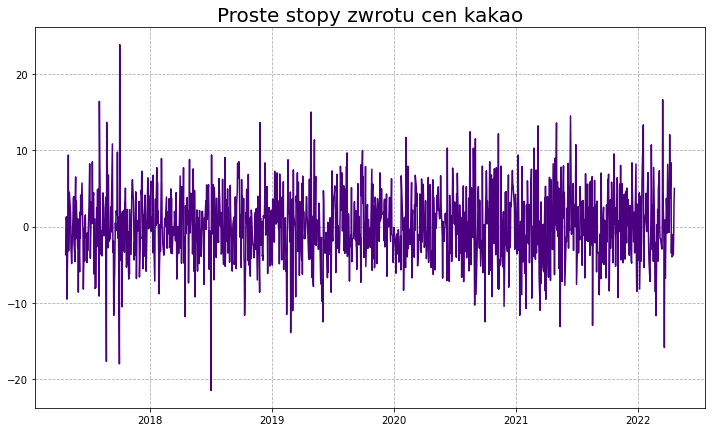

In [167]:
result = adfuller(cocoa_close)
print('p-value: {}'.format(result[1]))
plt.plot(cocoa['Date'][1:], np.flip(cocoa_close,axis=0), color='indigo')
plt.title("Proste stopy zwrotu cen kakao", fontsize=20)
plt.show()
#plt.savefig("cocoa_plot")

p-value: 1.6507126062903103e-23


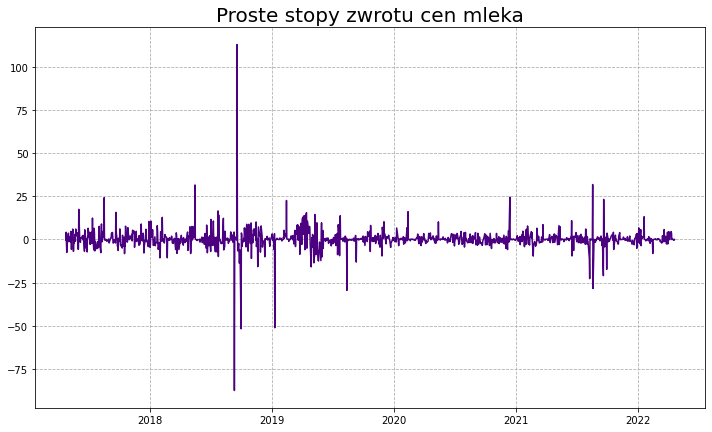

In [168]:
result = adfuller(milk_close)
print('p-value: {}'.format(result[1]))
plt.plot(milk['Date'][1:], np.flip(milk_close,axis=0), color='indigo')
plt.title("Proste stopy zwrotu cen mleka", fontsize=20)
plt.show()
#plt.savefig("milk_plot")

p-value: 0.0


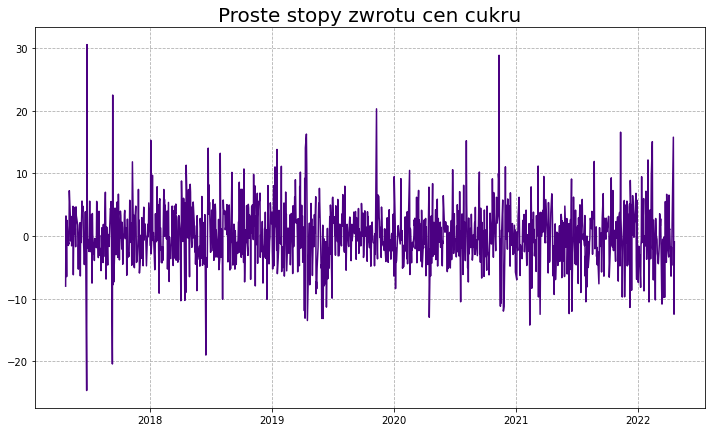

In [169]:
result = adfuller(sugar_close)
print('p-value: {}'.format(result[1]))
plt.plot(cocoa['Date'][1:], np.flip(sugar_close,axis=0), color='indigo')
plt.title("Proste stopy zwrotu cen cukru", fontsize=20)
plt.show()
#plt.savefig("sugar_plot")

In [14]:
mu_c = np.mean(cocoa_close)
sigma_c = np.std(cocoa_close)

mu_m = np.mean(milk_close)
sigma_m = np.std(milk_close)

mu_s = np.mean(sugar_close)
sigma_s = np.std(sugar_close)

Sprawdzenie normalności:

In [138]:
def normality(data):
    mu = np.mean(data)
    sigma = np.std(data)

    print("Test Kołmogorowa-Smirnowa: {}.".format(kstest((data-mu)/sigma, 'norm').pvalue))
    print("Test Jarque-Bera: {}.".format(jarque_bera(data).pvalue))
    print("Test Shapiro-Wilka: {}.".format(shapiro(data).pvalue))

    fig, axes = plt.subplots(1, 3, figsize=(20,6))

    x = np.arange(min(data), max(data)+1)
    axes[0].hist(data, bins=20, color='deeppink', alpha=0.6, density=True, label="Histogram prawdopodobieństwa danych")
    axes[0].plot(x, stats.norm.pdf(x, mu, sigma), color='indigo', label="Gęstość teoretyczna")
    axes[0].set_title('Porównanie gęstości')
    axes[0].legend(loc="best")

    ecdf = ECDF(data)
    axes[1].set_title('Porównanie dystrybuant')
    axes[1].plot(x, ecdf(x), color='deeppink', label='Dystrybuanta empiryczna')
    axes[1].plot(x, stats.norm.cdf(x, mu, sigma), color="indigo", linestyle='--', label="Dystrybuanta teoretyczna")
    axes[1].legend(loc="best")

    bplot = axes[2].boxplot(data, patch_artist=True, medianprops=dict(color="deeppink"))
    bplot['boxes'][0].set_facecolor('white')
    axes[2].grid(False)
    axes[2].set_title("Boxplot danych")

    plt.show()

Test Kołmogorowa-Smirnowa: 0.43854805735922275.
Test Jarque-Bera: 0.0.
Test Shapiro-Wilka: 2.0104769191675587e-06.


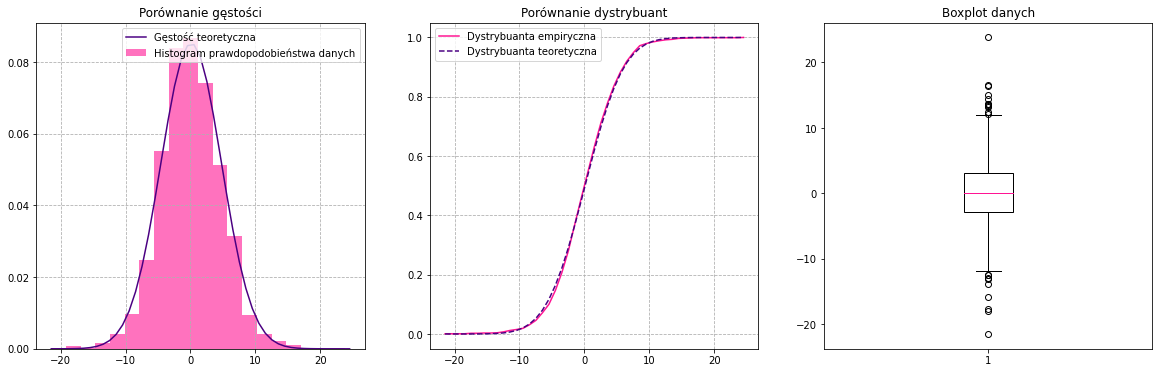

In [139]:
normality(cocoa_close)

Test Kołmogorowa-Smirnowa: 7.062311872527584e-40.
Test Jarque-Bera: 0.0.
Test Shapiro-Wilka: 0.0.


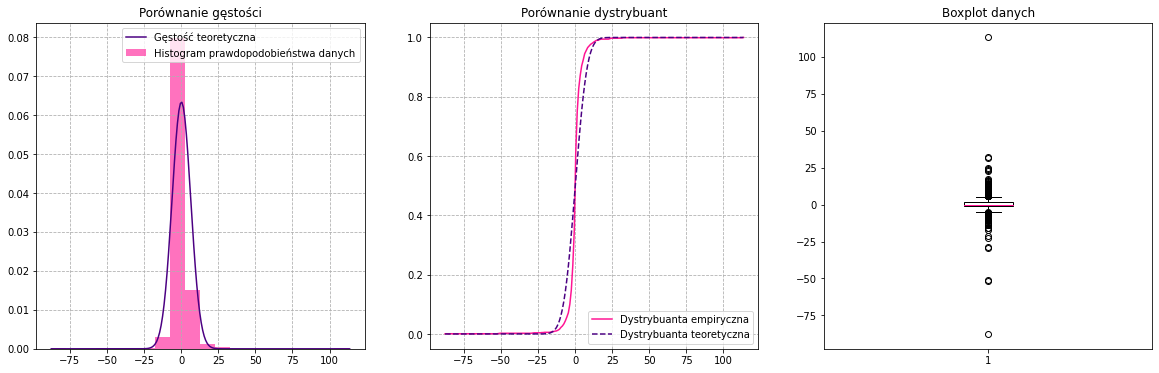

In [140]:
normality(milk_close)

Test Kołmogorowa-Smirnowa: 0.01246167523182368.
Test Jarque-Bera: 0.0.
Test Shapiro-Wilka: 4.5835192781028985e-17.


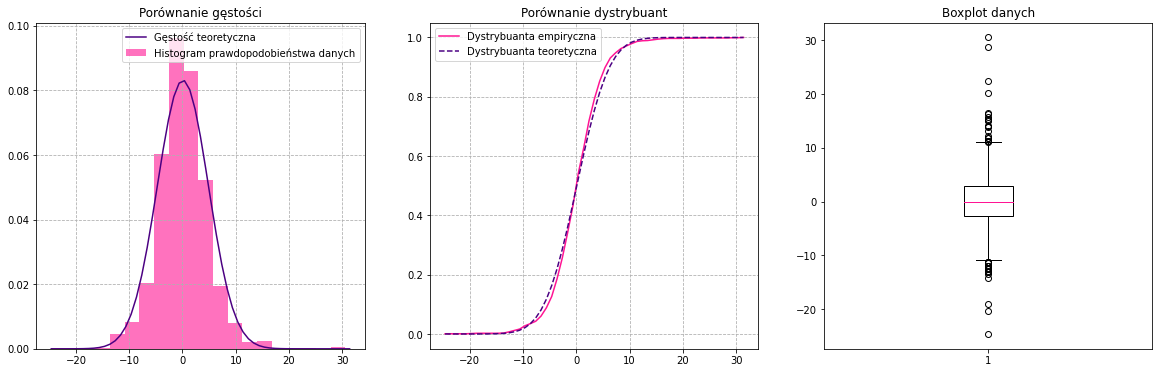

In [141]:
normality(sugar_close)

Sprawdzenie niezależności:

In [19]:
acorr_ljungbox(cocoa_close, lags=[30], return_df=True)

,lb_stat,lb_pvalue
30,40.948227,0.087766


In [20]:
acorr_ljungbox(milk_close, lags=[30], return_df=True)

,lb_stat,lb_pvalue
30,111.957554,2.199880e-11


In [21]:
acorr_ljungbox(sugar_close, lags=[30], return_df=True)

,lb_stat,lb_pvalue
30,24.414162,0.752972


P-wartość większa niż 0.05, więc nie mamy podstaw do odrzucenia hipotezy zerowej o niezależności.

## a) miary zmienności

In [22]:
# odchylenie standardowe
print("Kakao: {}, mleko: {}, cukier: {}.".format(sigma_c, sigma_m, sigma_s))

Kakao: 4.682475756840519, mleko: 6.295608405526686, cukier: 4.797462009740346.


In [23]:
# semi odchylenie standardowe
semi_std_c = np.std(cocoa_close[cocoa_close - mu_c > 0])
semi_std_m = np.std(milk_close[milk_close - mu_m > 0])
semi_std_s = np.std(sugar_close[sugar_close - mu_s > 0])
print("Kakao: {}, mleko: {}, cukier: {}.".format(semi_std_c, semi_std_m, semi_std_s))

Kakao: 2.989273792607109, mleko: 6.071117422875424, cukier: 3.427491017159806.


In [142]:
# odchylenie przeciętne
opc = np.sum(np.abs(cocoa_close - mu_c))/len(cocoa_close)
opm = np.sum(np.abs(milk_close - mu_m))/len(milk_close)
ops = np.sum(np.abs(sugar_close - mu_m))/len(sugar_close)
print("Kakao: {}, mleko: {}, cukier: {}.".format(opc, opm,ops))

Kakao: 3.6363676405180554, mleko: 2.8099429581201214, cukier: 3.532075314132211.


In [25]:
# odchylenie ćwiartkowe
IQR_c = (np.quantile(cocoa_close, 0.75) - np.quantile(cocoa_close, 0.25))/2
IQR_m = (np.quantile(milk_close, 0.75) - np.quantile(milk_close, 0.25))/2
IQR_s = (np.quantile(sugar_close, 0.75) - np.quantile(sugar_close, 0.25))/2
print("Kakao: {}, mleko: {}, cukier: {}.".format(IQR_c, IQR_m, IQR_s))

Kakao: 3.0002500000000003, mleko: 1.3577500000000002, cukier: 2.77975.


## b) kwantyle

In [26]:
Q1_c = np.quantile(cocoa_close, 0.25)
Q1_m = np.quantile(milk_close, 0.25)
Q1_s = np.quantile(sugar_close, 0.25)
print("Kakao: {}, mleko: {}, cukier: {}.".format(Q1_c, Q1_m, Q1_s))

Kakao: -2.865, mleko: -1.2425000000000002, cukier: -2.7385.


In [27]:
Q2_c = np.quantile(cocoa_close, 0.5)
Q2_m = np.quantile(milk_close, 0.5)
Q2_s = np.quantile(sugar_close, 0.5)
print("Kakao: {}, mleko: {}, cukier: {}.".format(Q2_c, Q2_m, Q2_s))

Kakao: 0.0, mleko: 0.0, cukier: 0.0.


In [28]:
Q3_c = np.quantile(cocoa_close, 0.75)
Q3_m = np.quantile(milk_close, 0.75)
Q3_s = np.quantile(sugar_close, 0.75)
print("Kakao: {}, mleko: {}, cukier: {}.".format(Q3_c, Q3_m, Q3_s))

Kakao: 3.1355, mleko: 1.473, cukier: 2.8209999999999997.


## c) wartości dystrybuanty

In [29]:
ecdf_c = ECDF(cocoa_close)
ecdf_m = ECDF(milk_close)
ecdf_s = ECDF(sugar_close)

In [30]:
print("Kakao: {}, mleko: {}, cukier: {}.".format(1-ecdf_c(0), 1-ecdf_m(0), 1-ecdf_s(0)))

Kakao: 0.4956314535345513, mleko: 0.4805401111993646, cukier: 0.48689436060365376.


## d) ($*$) miary wrażliwości

### Zmienna ryzyka: kontrakty futures na kakao.

In [193]:
cocoa_futures = pd.read_csv('cocoa-futures.csv')
cocoa_futures["date"] = pd.to_datetime(cocoa_futures["date"])

In [194]:
avg_c = cocoa_futures.groupby(pd.Grouper(key="date", freq="M")).mean()

In [195]:
avg_c = avg_c[:-28]

In [196]:
avg_c = np.array(avg_c).reshape(16,12)

In [197]:
avg_c = pd.DataFrame(avg_c)

In [198]:
avg_c_copy = []

for i in range(len(avg_c)):
    avg_c_copy.append(np.array(avg_c.iloc[i]/(avg_c.iloc[i].mean())))

In [199]:
cocoa_prices = np.asarray(avg_c_copy).reshape(192,1)

In [38]:
#T = 1/12
#cocoa_futures_copy = np.array([round((avg_c[0,i] - avg_c[0,i-1])/(avg_c[0,i-1] * T),3) for i in range(1, len(avg_c[0]))])

### Czynnik ryzyka: opady w Ghanie.

In [39]:
precip = pd.read_csv('ghana_precipitation.csv')
precip = precip[np.logical_and(precip['Year'] >= 2004,precip['Year'] < 2020)]
precip.reset_index(inplace=True)

In [40]:
Precip = precip.iloc[:,2:14]

In [41]:
Precip_copy = []

for i in range(len(Precip)):
    Precip_copy.append(np.array(Precip.iloc[i]/(Precip.iloc[i].mean())))

In [42]:
precipitation = np.asarray(Precip_copy).reshape(192,1)

In [43]:
#Precip_copy = np.array([round((Precip['Precipitation'][i] - Precip['Precipitation'][i-1])/(Precip['Precipitation'][i-1] * T),3) for i in range(1, len(Precip['Precipitation']))])

### Czynnik ryzyka: średnia temperatura w Ghanie.

In [44]:
temp = pd.read_csv('ghana_mean_temp.csv')
temp = temp[np.logical_and(temp['Year'] >= 2004,temp['Year'] < 2020)]
temp.reset_index(inplace=True)

In [45]:
Temp = temp.iloc[:,2:14]

In [46]:
Temp_copy = []

for i in range(len(Temp)):
    Temp_copy.append(np.array(Temp.iloc[i]/(Temp.iloc[i].mean())))

In [47]:
mean_temp = np.asarray(Temp_copy).reshape(192,1)

### Czynnik ryzyka - kurs walutowy PLN/USD (bo kupujemy surowce w USD).

In [48]:
rate_of_exchange = pd.read_csv("PLNUSD=X.csv")
rate_of_exchange["Date"] = pd.to_datetime(rate_of_exchange["Date"])
rate_of_exchange = rate_of_exchange.drop(["Open","High", "Low", "Adj Close", "Volume"], axis=1)

In [49]:
avg = rate_of_exchange.groupby(pd.Grouper(key="Date", freq="M")).mean()

In [50]:
avg = avg[:-28]

In [51]:
avg = np.array(avg).reshape(16,12)

In [52]:
avg = pd.DataFrame(avg)

In [53]:
avg_copy = []

for i in range(len(avg)):
    avg_copy.append(np.array(avg.iloc[i]/(avg.iloc[i].mean())))

In [54]:
plnusd = np.asarray(avg_copy).reshape(192,1)

In [55]:
#T = 1/12
#plnusd_close = np.array([round((avg['Close'][i] - avg['Close'][i-1])/(avg['Close'][i-1] * T),3) for i in range(1, len(avg['Close']))])


### Czynnik ryzyka - kurs walutowy USD/GHS.

In [56]:
rate_of_exchange = pd.read_csv("USDGHS=X.csv")
rate_of_exchange["Date"] = pd.to_datetime(rate_of_exchange["Date"])
rate_of_exchange = rate_of_exchange.drop(["Open","High", "Low", "Adj Close", "Volume"], axis=1)

In [57]:
avg_g = rate_of_exchange.groupby(pd.Grouper(key="Date", freq="M")).mean()

In [58]:
avg_g = avg_g[6:-28]

In [59]:
avg_g = np.array(avg_g).reshape(12,12)

In [60]:
avg_g = pd.DataFrame(avg_g)

In [61]:
avg_g_copy = []

for i in range(len(avg_g)):
    avg_g_copy.append(np.array(avg_g.iloc[i]/(avg_g.iloc[i].mean())))

In [62]:
usdghs = np.asarray(avg_g_copy).reshape(144,1)

### Dobieranie funkcji zależności opisującej zmienną ryzyka.

In [200]:
data = pd.concat([pd.DataFrame(precipitation[48:],columns=['Precipitation']), pd.DataFrame(mean_temp[48:],columns=['Temperature']), pd.DataFrame(plnusd[48:],columns=['PLNUSD']), pd.DataFrame(usdghs,columns=['USDGHS']),pd.DataFrame(cocoa_prices[48:],columns=['cocoa'])],axis=1)

In [201]:
data.head()

,Precipitation,Temperature,PLNUSD,USDGHS,cocoa
0,0.032541,0.926551,0.970912,0.893485,0.853839
1,0.312003,1.054025,0.983608,0.898267,0.977606
2,0.732281,1.088989,1.046204,0.899518,1.025721
3,1.195553,1.082433,1.091432,0.913419,1.016085
4,1.347413,1.039456,1.090218,0.920701,1.040835


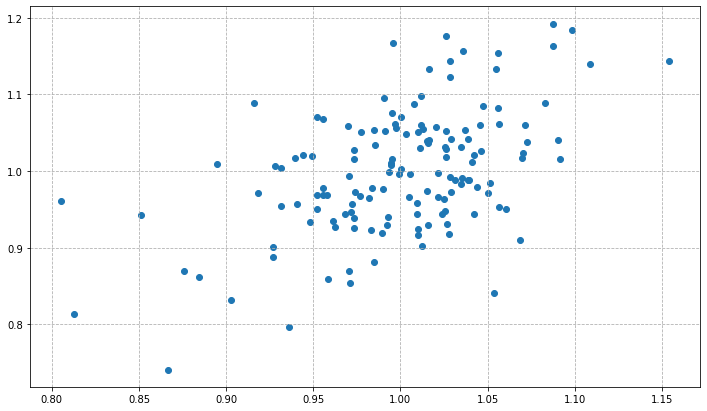

In [202]:
plt.scatter(data['PLNUSD'], data['cocoa'])
plt.show()

In [66]:
y = data['cocoa']
x = data.iloc[:,[0,1,2,3]]

In [67]:
x = sm.add_constant(x)

In [68]:
model = sm.GLS(y, x).fit()

In [69]:
print(model.summary())

                            GLS Regression Results                            
Dep. Variable:                  cocoa   R-squared:                       0.339
Model:                            GLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     17.81
Date:                Mon, 25 Apr 2022   Prob (F-statistic):           7.92e-12
Time:                        16:59:36   Log-Likelihood:                 188.02
No. Observations:                 144   AIC:                            -366.0
Df Residuals:                     139   BIC:                            -351.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.2757      0.237     -1.163

In [70]:
b, a1, a2, a3, a4 = model.params

In [180]:
daty = pd.date_range(start="2008-01-01",end="2020-01-01",freq="M")

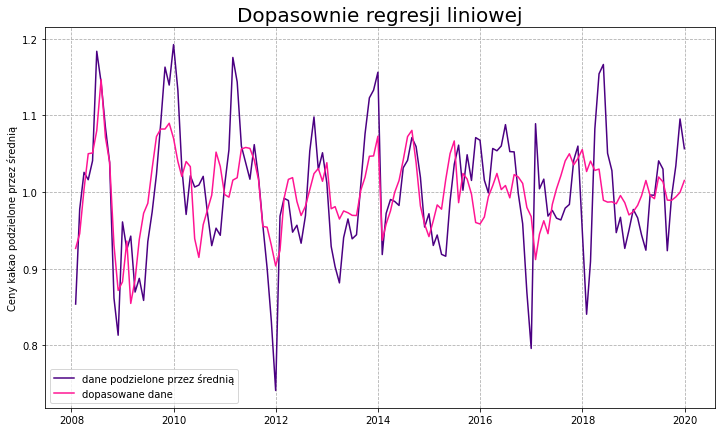

In [204]:
plt.plot(daty, data['cocoa'], color='indigo',label='dane podzielone przez średnią')
plt.plot(daty, (data['Precipitation']*a1 + data['Temperature']*a2 + data['PLNUSD']*a3 + data["USDGHS"]*a4 + b),color='deeppink',label='dopasowane dane')
plt.ylabel("Ceny kakao podzielone przez średnią")
plt.title("Dopasownie regresji liniowej", fontsize=20)
plt.legend()
plt.show()
#plt.savefig("reg_plot")

In [72]:
# prarametry regresji liniowej = miary wrażliwości zmiennej R na poszczególne czynniki ryzyka?
betas = model.params

In [73]:
betas

const           -0.275728
Precipitation    0.006006
Temperature      0.038125
PLNUSD           0.855883
USDGHS           0.375713
dtype: float64

Otrzymaliśmy zatem funkcję liniową opisującą wpływ czynników ryzyka na zmienną ryzyka dotyczącą cen kakao:
$$R = 0.00601 \cdot \beta_P + 0.03813 \cdot \beta_T + 0.85588 \cdot \beta_{PU} + 0.37571 \cdot \beta_{UG} - 0.27573,$$
gdzie:
* $\beta_P$ - opady w Ghanie,
* $\beta_T$ - średnia temperatura w Ghanie,
* $\beta_{PU}$ - kurs walut PLN/USD,
* $\beta_{UG}$ - kurs walut USD/GHS.

# 2. Analiza wielowymiarowa.

Tworzymy portfel ryzyk:
$$R_p = 0.5 \cdot R_c + 0.3 \cdot R_s + 0.2 \cdot R_m,$$ 
gdzie:
* $R_c$ - zmienna ryzyka związana ze zmianą cen kakao,
* $R_s$ - zmienna ryzyka związana ze zmianą cen cukru,
* $R_m$ - zmienna ryzyka związana ze zmianą cen mleka.

In [74]:
wc = 0.5
ws = 0.3
wm = 0.2
w = np.array([wc,wm,ws])

Rp = wc * cocoa_close + wm * milk_close + ws * sugar_close

## a) miary zmienności

In [75]:
n = len(cocoa_close)
C = cocoa_close.reshape(1,n)
M = milk_close.reshape(1,n)
S = sugar_close.reshape(1,n)
R = np.concatenate([C,M,S],axis=0)

In [76]:
# odchylenie standardowe - 1 sposób
np.sqrt(np.dot(w.T, np.dot(np.cov(R), w)))

3.1355931254655873

In [77]:
cov = np.cov(R)

In [78]:
# odchylenie standardowe - 2 sposób
np.sqrt(np.sum([w[i]**2*cov[i,i] for i in range(3)]) + 2 * np.sum([np.sum([w[i]*w[j]*cov[i,j] for j in range(i+1, 3)]) for i in range(2)]))

3.1355931254655873

In [79]:
#semiodchylenie ćwiartkowe
(np.quantile(Rp, 0.75) - np.quantile(Rp, 0.25))/2

1.9359749999999998

## b) kwantyle

In [80]:
np.quantile(Rp, 0.25)

-1.82835

In [81]:
np.quantile(Rp, 0.5)

0.09520000000000006

In [82]:
np.quantile(Rp, 0.75)

2.0435999999999996

## c) wartości dystrybuanty

Dystrybuanta wielowymiarowa jest w pliku multivariate_cdf.R.

In [83]:
ecdf_p = ECDF(Rp)

In [84]:
1 - ecdf_p(0)

0.511517077045274

In [85]:
# cocoa_close.to_csv('cocoa_close.csv',index=False)
# milk_close.to_csv('milk_close.csv',index=False)
# sugar_close.to_csv('sugar_close.csv',index=False)

# 3. Ryzyko ekstremalne.

## Dopasowanie rozkładu granicznego.

In [144]:
L = cocoa_close[cocoa_close > 0]

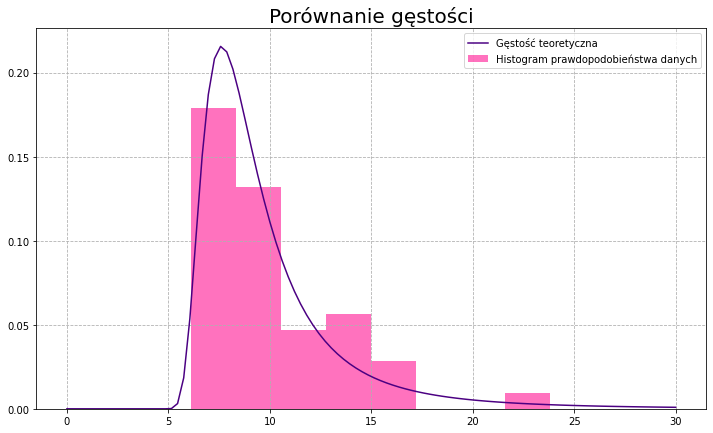

In [205]:
M = [L[i*13:(i+1)*13].max() for i in range(48)]
t = np.linspace(0,30,100)
plt.hist(M, density=True, bins="auto", label="Histogram prawdopodobieństwa danych", color='deeppink', alpha=0.6)
fit = gev.fit(M)
pdf = gev.pdf(t, *fit)
plt.plot(t, pdf, label="Gęstość teoretyczna", color='indigo')
plt.title("Porównanie gęstości", fontsize=20)
plt.legend()
#plt.savefig("gev_dens")
plt.show()

In [88]:
print("parametry rozkładu: ", fit) #shape, location, scale wychodzi ze to rozkład Weibulla bo shape < 0

parametry rozkładu:  (-0.34476528834771913, 8.123839390596675, 1.7998814451274279)


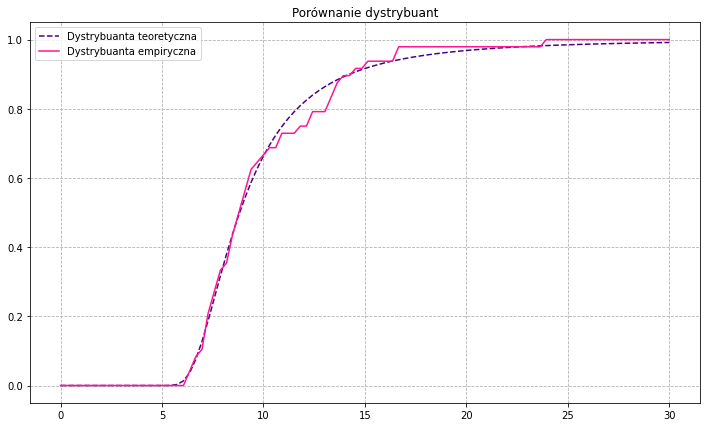

In [206]:
cdf = gev.cdf(t, *fit)
ecdf = ECDF(M)
plt.plot(t, cdf, color="indigo", linestyle='--', label="Dystrybuanta teoretyczna")
plt.plot(t, ecdf(t), color="deeppink", label="Dystrybuanta empiryczna")
plt.title("Porównanie dystrybuant")
plt.legend()
#plt.savefig("gev_distr")
plt.show()

## Dopasowanie rozkładu warunkowego przekroczenia.

In [90]:
L_sort = np.sort(L)

In [91]:
def e(v,L_sort):
    L_v = L_sort[L_sort > v]
    return np.mean([L_v[i] - v for i in range(len(L_v))])

In [92]:
y = [e(L_sort[i],L_sort) for i in range(len(L_sort)-1)]

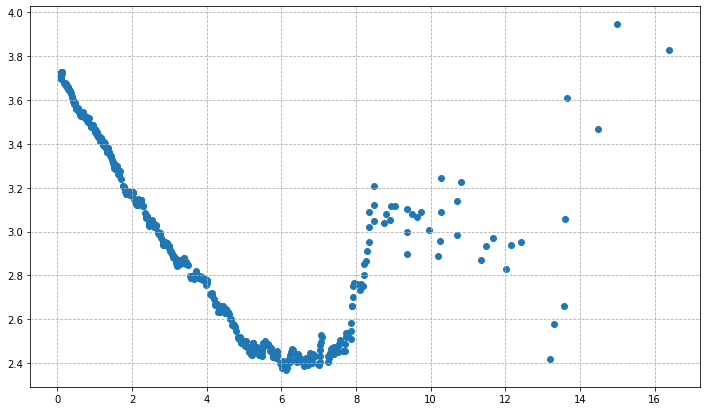

In [93]:
plt.scatter(L_sort[:-2],y[:-1])
plt.show()

In [94]:
Ls = sugar_close[sugar_close > 0]

In [95]:
Ls_sort = np.sort(Ls)

In [96]:
ys = [e(Ls_sort[i],Ls_sort) for i in range(len(Ls_sort)-1)]

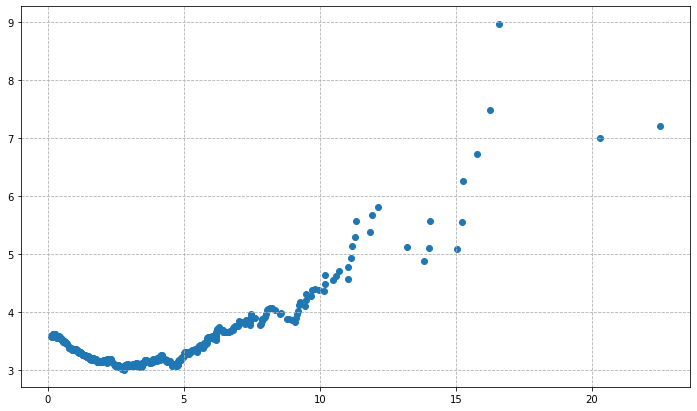

In [97]:
plt.scatter(Ls_sort[:-2],ys[:-1])
plt.show()

# 4. Testowanie wsteczne

In [98]:
train = cocoa_close[252:] # ceny kako do 23.04.2021
test = cocoa_close[:252] # ceny kako od 26.04.2021 do 22.04.2022

In [99]:
print("Test Kołmogorowa-Smirnowa: {}.".format(kstest((train-np.mean(train))/np.std(train), 'norm').pvalue))
print("Test Jarque-Bera: {}.".format(jarque_bera(train).pvalue))
print("Test Shapiro-Wilka: {}.".format(shapiro(train).pvalue))

Test Kołmogorowa-Smirnowa: 0.7120744884965741.
Test Jarque-Bera: 0.0003423728057322384.
Test Shapiro-Wilka: 0.00949539989233017.


Niestety tylko na podstawie testu Kołmogorowa-Smirnowa możemy powiedzieć, że dane mają rozkład normalny.

## Odchylenie standardowe

In [100]:
sigma1 = train.std()
sigma2 = test.std()
print("sigma1 = {}, sigma2 = {}".format(sigma1, sigma2))

sigma1 = 4.6465407336608315, sigma2 = 4.8233262404789805


In [101]:
F = sigma1**2/sigma2**2
df1 = len(train) - 1
df2 = len(test) - 1
print("P-value for F test: {}.".format(f.sf(F, df1, df2))) # p-value

P-value for F test: 0.7804295007603235.


P wartość jest większa od zadanego poziomu istotności (0.05), czyli nie mamy podstaw do odrzucenia hipotezy zerowej o równości warincji. To znaczy, że za pomocą danych historycznych możemy przewidzieć odchylenie standardowe z okresu 26.04.2021 - 22.04.2022.

## Kwantyle

In [102]:
train_copy = train

In [103]:
I = []
for i in range(len(test)):
    q = np.quantile(train_copy,0.25)
    if test[i] < q:
        I.append(1)
    else:
        I.append(0)
    np.append(train_copy,test[i])

In [104]:
np.mean(I) # powinna być równa 0.25

0.23809523809523808

In [105]:
np.var(I) # powinna być równa 0.1875 (0.25 * (1-0.25))

0.18140589569160995

In [106]:
print("P-wartość: {}.". format(binom_test(sum(I), n=len(I), p=0.25, alternative='two-sided')))

P-wartość: 0.7162059041317934.


P-wartość większa niż 0.05, więc możemy założyć, że hipoteza zerowa (p=0.25) jest prawdziwa i dane wpadają poniżej kwantyla rzędu 0.25 z prawdopodobieństwem 25%.

Zatem nasze szacowanie było poprawne.